# Visualization of the results of the model for the transport on TEST data

In [82]:
import os
notebook_path = os.getcwd()
import numpy as np
import sys
sys.path.append('/mydata/watres/quentin/code/TRANSPORT/')
from BERT4Transit import *
from BERT4Transit.visualization import *
import pandas as pd

In [83]:
if False:
    sites = ['Basel_small_storage','Basel_large_storage','Pully_small_storage','Pully_large_storage','Lugano_small_storage','Lugano_large_storage' ]
    #sites = ['Pully_small_storage','Pully_large_storage','Lugano_small_storage' ]
    sitenames = ['Site A-small', 'Site A-large', 'Site B-small', 'Site B-large', 'Site C-small', 'Site C-large']
    site2name = {site: sitenames[i] for i, site in enumerate(sites)}
    algos = ['SumSquares_noBERT2_bayesian3'] #['SumSquares_noBERT2', 'AgeDomain', 'Weibull']
    algo2name = {'SumSquares_noBERT2': 'WATRES'}
    settings = []
    for site in sites:
        pathsite = f'{notebook_path}/data/{site}/'
        for algo in algos:
            settings.append({'site':site, 
                             'pathsite': f'{notebook_path}/data/{site}/',
                             'algo': algo,
                            'path_model': os.path.join(pathsite, 'save', f'save_BERT4TRANSIT_{site}_no_c_{algo}.pth.tar'),
                            'path_results': os.path.join(pathsite, 'save', f'results_BERT4TRANSIT_{site}_no_c_{algo}.pkl')
                            })
else:
    mode2stride = { '2_weeks': 24*7*2,
               '1_week': 24*7,
              'daily': 24,
              #'12_hours': 12,
               '6_hours': 6,
              # '3_hours':3,
              # '2_hours':2,
               'hourly': 1}
    sites = list(mode2stride.keys())

    algos = ['SumSquares_noBERT2_bayesian3'] #['SumSquares_noBERT2', 'AgeDomain', 'Weibull']
    
    algo2name = {'SumSquares_noBERT2_bayesian3': 'WATRES'}
    settings = []
    years_training = 10
    for site in sites:
        for seed in range(0,9):
            pathsite = f'/mydata/watres/quentin/code/TRANSPORT/data/Pully_small_storage/subsampling/{site}/'
            for algo in algos:
                site_name2save=site+'_noise_0.1_yearstrain_'+str(years_training)+'_'+str(seed)
                settings.append({
                    'site': f'{site}_{seed}',
                    'pathsite': pathsite,
                    'algo': algo,
                    'path_model': os.path.join(pathsite, 'save', f'save_BERT4TRANSIT_{site_name2save}_no_c_{algo}.pth.tar'),
                    'path_results': os.path.join(pathsite, 'save', f'results_{site_name2save}.pkl')
                
                    #'path_results': os.path.join(pathsite, 'save', f'results_BERT4TRANSIT_{site}_{seed}_no_c_{algo}.pkl')
                })


results = gather_results_all_sites(settings)

# Comparison with EHS

In [31]:
from scipy.interpolate import interp1d
root_data = '/mydata/watres/quentin/code/TRANSPORT/data/'
# getting dates at the hour resolution used to test
hours_test = np.array([fractional_year_to_datetime(el) for el in np.array(results[sites[0]][algos[0]]['timeyear_test'])])

## Getting results from EHS
res_EHS = {}
for site in sites:
    res_EHS[site] = {}
    EHS_global = pd.read_csv(os.path.join(root_data, site, 'save', 'EHS_global.txt'), sep=' ')
    res_EHS[site]['TTD_lag'] = EHS_global['TTD_lag'].to_numpy().reshape(-1) * (24*7)
    res_EHS[site]['globalPQ'] = np.cumsum(EHS_global['TTD.TTD'].to_numpy().reshape(-1))
    res_EHS[site]['globalPQ_se'] = np.cumsum(EHS_global['TTD.TTD_se'].to_numpy().reshape(-1))

    x_vals = EHS_global['TTD_lag'].to_numpy().reshape(-1)
    y_vals = res_EHS[site]['globalPQ']
    f = interp1d(x_vals, y_vals, kind='linear', fill_value="extrapolate")
    res_EHS[site]['ywfhat'] = (np.array([f(i*4) for i in range(1,11)])).reshape(1,-1)
    for k in range(4):
        EHS_quantile = pd.read_csv(os.path.join(root_data, site, 'save', 'EHS_quantile{0}.txt'.format(k)), sep=' ') 
        res_EHS[site]['quantile{0}_PQ'.format(k)] = np.cumsum(EHS_quantile['QquantileTTD.TTD'].to_numpy().reshape(-1))
        y_vals = res_EHS[site]['quantile{0}_PQ'.format(k)]
        f = interp1d(x_vals, y_vals, kind='linear', fill_value="extrapolate")
        res_EHS[site]['quantile{0}_ywfhat'.format(k)] = (np.array([f(i*4) for i in range(1,11)]))

In [80]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

def show_global_cum_ttd_row(results, algo2name=None, site2name=None):
    # Default mapping for site names
    if site2name is None:
        site2name = {el: el for el in results.keys()}
    
    # Default mapping for algorithm names
    if algo2name is None:
        algo2name = {el: el for el in results[list(results.keys())[0]].keys()}
    
    # Define colors and markers
    colors = ['Teal',  'Coral']
    markers = ['*', '.', 'o', '^', 's', 'd']
    
    # X-axis values for plotting
    x_abs = np.arange(365 * 24) / (24 * 30)
    
    # Count for subplot management
    count = 0
    num_sites = len(results)
    num_cols = 3  # Number of columns for subplots
    num_rows = 1
    
    # Create a figure for subplots
    plt.figure(figsize=(15, 5 * num_rows))

    maxT= 24*30*8

    titles = ['Site A', 'Site B', 'Site C']
    for site, res_site in results.items():
        if count%2==0:
            plt.subplot(num_rows, num_cols, count//2 + 1)
            legend_patches = []
            legend_patches.append(Patch(facecolor=colors[0], edgecolor='black', label=sitenames[count][:6]+' small storage'))
            legend_patches.append(Patch(facecolor=colors[1], edgecolor='black', label=sitenames[count][:6]+' large storage'))


        
        # Check if the algorithm and required keys exist
        algo = 'SumSquares_noBERT2_bayesian3'
        if algo not in res_site or 'global_PQhat' not in res_site[algo] or 'global_PQtrue' not in res_site[algo]:
            print(f"Missing data for site: {site} or algorithm: {algo}")
            count += 1
            continue
        
        # Plot predicted and true cumulative TTD
        plt.plot(
            x_abs[:maxT], 
            res_site[algo]['global_PQhat'][:365 * 24][:maxT], 
             linestyle='--', 
            color=colors[count%2]
        )
        plt.plot(
            x_abs[:maxT], 
            res_site[algo]['global_PQtrue'][:365 * 24][:maxT], 
            color=colors[count%2]
        )

        plt.plot(
            res_EHS[site]['TTD_lag']/(24*30), 
            res_EHS[site]['globalPQ'], 
            linestyle='-.',
            color=colors[count%2]
        )
        x = res_EHS[site]['TTD_lag']/(24*30)
        y_low = res_EHS[site]['globalPQ'] - res_EHS[site]['globalPQ_se']
        y_up = res_EHS[site]['globalPQ']  + res_EHS[site]['globalPQ_se'] 
        plt.fill_between(x, y_low, y_up, alpha=0.2, color=colors[count%2])

        if count%2==1:    
            # Set axis labels and title
            plt.xlabel('Age (in Months)', fontsize=13)
            plt.ylabel('Averaged cumulative TTD', fontsize=14)
            plt.title(titles[count//2], fontsize=14)
            plt.ylim(top=1)
            # Add the GISID color blocks to the legend
            ax = plt.gca()
            gisid_legend = ax.legend(handles=legend_patches, loc='upper right', fontsize=12)
            
            method_legend_lines = [
                Line2D([0], [0], color='black', linestyle='--', lw=1, label='WATRES'),
                Line2D([0], [0], color='black', linestyle='-.', lw=1, label='EHS'),
                Line2D([0], [0], color='black', lw=1, label='Ground truth')
            ]
            method_legend = ax.legend(handles=method_legend_lines, loc='upper left', fontsize=12)
            ax.add_artist(gisid_legend)  # Add GISID legend manually so it doesn't get overwritten


        
        count += 1
    
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.savefig('global_ttd_watres_gt.png'.format(site2name[site]), dpi=250, bbox_inches="tight")

    plt.show()

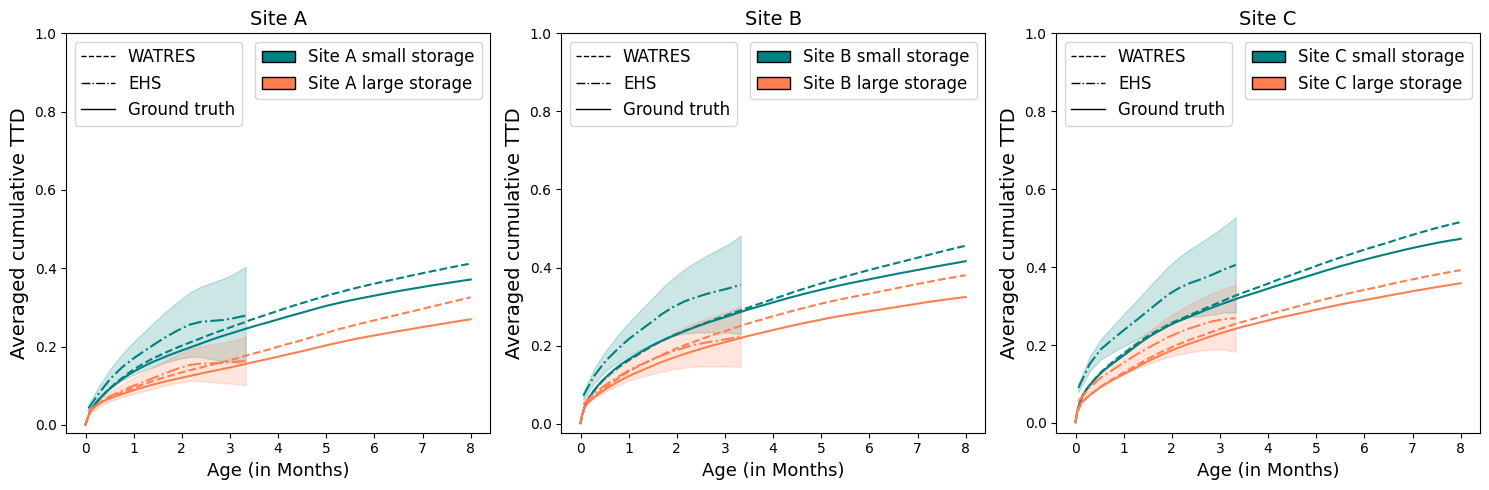

In [81]:
show_global_cum_ttd_row(results, algo2name=algo2name, site2name=site2name)

In [75]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

def show_global_quantiles_cum_ttd_row(results, sites, titles, algo2name=None, site2name=None):
    # Default mapping for site names
    if site2name is None:
        site2name = {el: el for el in results.keys()}
    
    # Default mapping for algorithm names
    if algo2name is None:
        algo2name = {el: el for el in results[list(results.keys())[0]].keys()}
    
    # Define colors and markers
    colors = ['#AEC6CF', 'black', '#77DD77', 'red', '#CBAACB']
    markers = ['*', '.', 'o', '^', 's', 'd']
    
    # X-axis values for plotting
    x_abs = np.arange(365 * 24) / (24 * 30)
    
    # Count for subplot management
    num_sites = len(results)
    num_cols = 3  # Number of columns for subplots
    num_rows = 1
    
    # Create a figure for subplots
    plt.figure(figsize=(15, 5 * num_rows))

    
    for count, site in enumerate(sites):
        plt.subplot(num_rows, num_cols, count+1)


        # Check if the algorithm and required keys exist
        algo = 'SumSquares_noBERT2_bayesian3'
        if algo not in results[site] or 'global_PQhat' not in results[site][algo] or 'global_PQtrue' not in results[site][algo]:
            print(f"Missing data for site: {site} or algorithm: {algo}")
            continue
        
        # Plot predicted and true cumulative TTD
        for i in range(4):
            plt.plot(
                x_abs, 
                results[site][algo]['quantile{0}_PQtrue'.format(i)][:365 * 24], 
                color=colors[1]
            )            
            plt.plot(
                x_abs, 
                results[site][algo]['quantile{0}_PQhat'.format(i)][:365 * 24], 
                 linestyle='--', 
                color=colors[3]
            )

    
            # plt.plot(
            #     res_EHS[site]['TTD_lag']/(24*30), 
            #     res_EHS[site]['quantile{0}_PQ'.format(i)], 
            #     linestyle='-.',
            #     color=colors[2]
            # )

        # Set axis labels and title
        plt.xlabel('Age (in Months)', fontsize=13)
        plt.ylabel('Averaged cumulative TTD', fontsize=14)
        plt.title(titles[count], fontsize=14)
        plt.ylim(top=1)
        # Add the GISID color blocks to the legend
        ax = plt.gca()
        
        method_legend_lines = [
            Line2D([0], [0], color=colors[3], linestyle='--', lw=1, label='WATRES'),
            #Line2D([0], [0], color=colors[2], linestyle='-.', lw=1, label='EHS'),
            Line2D([0], [0], color=colors[1], lw=1, label='Ground truth')
        ]
        method_legend = ax.legend(handles=method_legend_lines, loc='upper left', fontsize=12)


            
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.savefig('global_quantiles_ttd_watres_gt.png'.format(site2name[site]), dpi=250, bbox_inches="tight")

    plt.show()

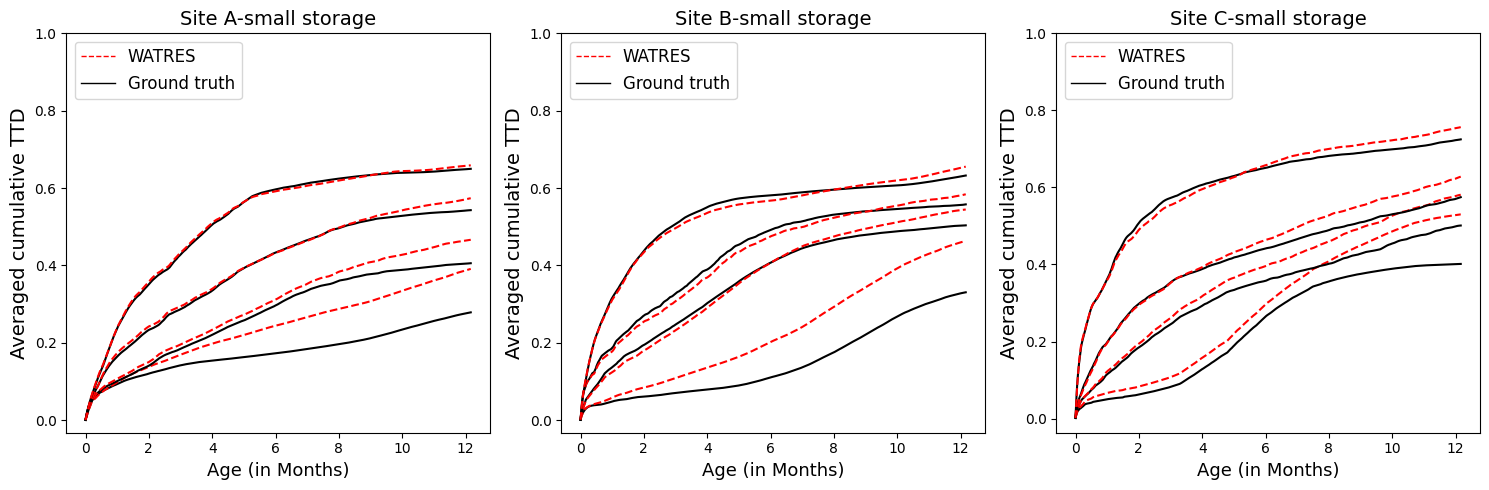

In [76]:
sites4q = [site for site in sites if 'small' in site]
titles = ['Site A-small storage', 'Site B-small storage', 'Site C-small storage']
show_global_quantiles_cum_ttd_row(results, sites4q, titles, algo2name=algo2name, site2name=site2name)

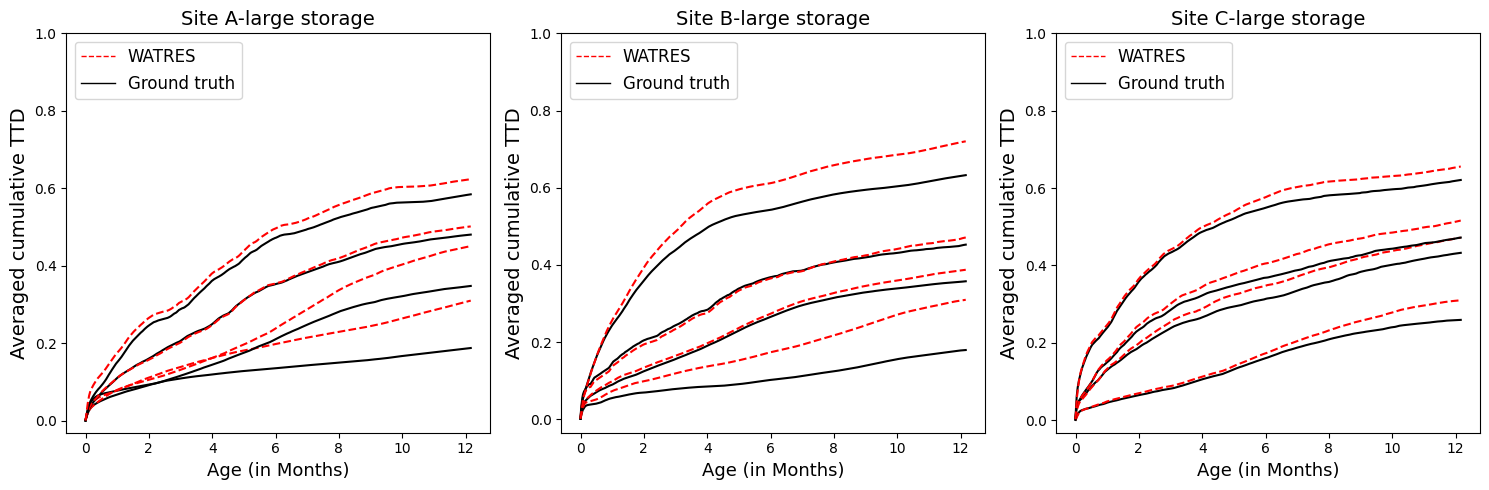

In [77]:
sites4q = [site for site in sites if 'large' in site]
titles = ['Site A-large storage', 'Site B-large storage', 'Site C-large storage']
show_global_quantiles_cum_ttd_row(results, sites4q, titles, algo2name=algo2name, site2name=site2name)

# 0. Impact of coarser resolution for the input tracer data

In [29]:
for i in range(len(settings)):
        model = BERT4Transit(pathsite=settings[i]['pathsite'], site=settings[i]['site'], algo=settings[i]['algo'], path_model=settings[i]['path_model'])
        model.load_model(settings[i]['path_model'])
        print(settings[i]['site'],len(model.lst_train))

2_weeks_0 260
2_weeks_1 260
2_weeks_2 260
2_weeks_3 260
2_weeks_4 260
2_weeks_5 260
2_weeks_6 260
2_weeks_7 260
2_weeks_8 260
1_week_0 519
1_week_1 519
1_week_2 519
1_week_3 519
1_week_4 519
1_week_5 519
1_week_6 519
1_week_7 519
1_week_8 519
daily_0 3638
daily_1 3638
daily_2 3638
daily_3 3638
daily_4 3638
daily_5 3638
daily_6 3638
daily_7 3638
daily_8 3638
6_hours_0 4000
6_hours_1 4000
6_hours_2 4000
6_hours_3 4000
6_hours_4 4000
6_hours_5 4000
6_hours_6 4000
6_hours_7 4000
6_hours_8 4000
hourly_0 4000
hourly_1 4000
hourly_2 4000
hourly_3 4000
hourly_4 4000
hourly_5 4000
hourly_6 4000
hourly_7 4000
hourly_8 4000


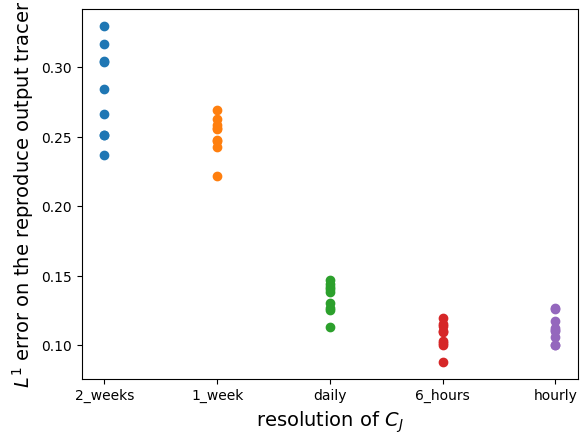

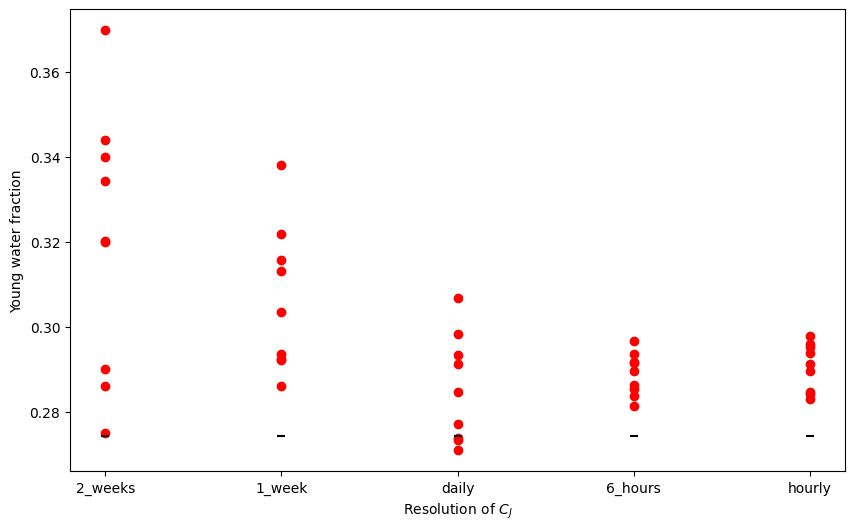

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

site2L2errorsCq = {site:[] for site in sites}
site2ywf = {site:[] for site in sites}
site2true_ywf = {site:None for site in sites}
for site in sites:
    for sitename, values in results.items():
        if site==sitename[:len(site)]:
            chat_values = np.array(values[algo]['Chat'])
            cout_values = np.array(values[algo]['Cout'])
            l2_error = np.abs((chat_values - cout_values) )#np.sqrt((chat_values - cout_values) ** 2)
            site2L2errorsCq[site].append(np.mean(l2_error))
            site2ywf[site].append(np.mean(values[algo]['ywfhat'][:,2]))
            site2true_ywf[site] = np.mean(values[algo]['ywf_true'][:,2])



# Create the box plot using seaborn
#sns.boxplot(x=model_names, y=np.log10(l2_errors))
for i, site in enumerate(sites):
    plt.scatter([i for k in range(len(site2ywf[site]))], site2L2errorsCq[site])
plt.xticks(ticks=[i for i in range(len(sites))], labels=sites)
#plt.title('$L^2$ errors for different resolution of $C_J$')
plt.xlabel('resolution of $C_J$', fontsize=14)
plt.ylabel('$L^1$ error on the reproduce output tracer', fontsize=14)
plt.savefig('L2error_CQ_subsampling.png', dpi=250, bbox_inches="tight")
plt.show()


# Create the box plot using seaborn
plt.figure(figsize=(10, 6))
#sns.boxplot(x=model_names, y=np.log10(l2_errors))
for i, site in enumerate(sites):
    plt.scatter([i for k in range(len(site2ywf[site]))], site2ywf[site], color='red')
    plt.scatter([i], [site2true_ywf[site]], marker='_', color='black')
plt.xticks(ticks=[i for i in range(len(sites))], labels=sites)
plt.xlabel('Resolution of $C_J$')
plt.ylabel('Young water fraction')
plt.show()

In [31]:
def show_quantile_ywf_subsampling(results, sites, nb_groups = 10, months_ywf=3):
    from matplotlib.lines import Line2D
    count_site = -1
    colors = np.flip(get_colors_rainbow(K=nb_groups))
    markers = ["o", "s", "D", "*", "X", "v", "P", "d"]

    min_val_glob, max_val_glob = 1, 0

    algo = list(results[list(results.keys())[0]].keys())[0]
    site2data = {site:np.zeros(nb_groups) for site in sites}
    site2true = {site:np.zeros(nb_groups) for site in sites}
    site2count = {site:0 for site in sites}
    for site_ref in sites:
        for site, res_site in results.items():
            value = res_site[algo]
            if site_ref==site[:len(site_ref)]:
                site2count[site_ref] += 1
                Q_test = value['Q_test']
                # Get quantile bins (10 quantiles)
                quantile_bins = np.quantile(Q_test, np.linspace(0, 1, nb_groups+1))
                # Assign each value to a quantile bin
                quantile_indexes = np.digitize(Q_test, quantile_bins, right=True)
                # Create a dictionary to hold the indexes for each group
                grouped_indexes = {i: np.where(quantile_indexes == i)[0] for i in range(1, nb_groups+1)}
    
                data_pred = []
                data_true = []
                
                for idx_group, idxs in grouped_indexes.items():
                    if len(idxs) > 0:
                        data_pred.append(np.mean(value['ywfhat'][:, months_ywf-1][idxs]))
                        data_true.append(np.mean(value['ywf_true'][:, months_ywf-1][idxs]))
    
                # Find the axis limits based on the data
                all_data = np.concatenate((data_pred, data_true))
                min_val, max_val = np.min(all_data), np.max(all_data)
                max_val_glob = max([max_val_glob, max_val])
                min_val_glob = min([min_val_glob, min_val])
    
                
                # Plot with different colors for each group and create a legend entry
                for i in range(1, nb_groups+1):
                    if i in grouped_indexes and len(grouped_indexes[i]) > 0:
                        site2data[site_ref][i-1] += np.mean(value['ywfhat'][:, months_ywf-1][grouped_indexes[i]])
                        site2true[site_ref][i-1] += np.mean(value['ywf_true'][:, months_ywf-1][grouped_indexes[i]])

    for i in range(nb_groups):
        for count_site, site in enumerate(sites):
            plt.scatter(
                site2data[site][i]/site2count[site],
                site2true[site][i]/site2count[site],
                color=colors[i],
                marker=markers[count_site]
            )
    

    min_val_glob -= 0.05
    min_val_glob = max([min_val_glob,0])
    max_val_glob += 0.05
    # Set the same limits for x and y axes
    plt.xlim(min_val_glob, max_val_glob)
    plt.ylim(min_val_glob, max_val_glob)
    plt.plot([min_val_glob, max_val_glob], [min_val_glob, max_val_glob], linestyle='--', color='black')
    plt.xlabel('Predicted young water fraction', fontsize=14)
    plt.ylabel('Ground truth young water fraction', fontsize=14)
    # Custom legend for colors (Streamflow quantiles)
    color_legend = [Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i-1], markersize=10)
                    for i in range(1, nb_groups+1)]
    quantile_legend = plt.legend(color_legend, [f'Q{i}' for i in range(1, nb_groups+1)], 
                                 title="Streamflow quantiles",
                                 loc=5, bbox_to_anchor=(0.93, 0.2), ncol=2)
    
    # Add the color legend to the plot
    plt.gca().add_artist(quantile_legend)

    # Custom legend for markers (Sites)
    marker_legend = [Line2D([0], [0], marker=markers[i], color='w', markerfacecolor='grey', markersize=10)
                     for i in range(len(sites))]
    plt.legend(marker_legend, sites, title="Input tracer resolution", loc=1, bbox_to_anchor=(0.6, 0.95), ncol=2)

    plt.tight_layout()
    plt.savefig('ywf_true_vs_pred_subsampling.png', dpi=250, bbox_inches="tight")
    plt.show()

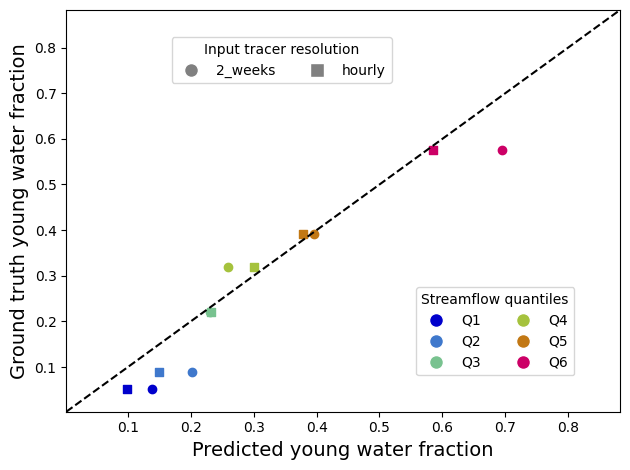

In [34]:
site2include = ['2_weeks', 'hourly']
def f(a):    
    res = False
    for site in site2include:
        res = res or (a[:len(site)]==site)
    return (res)
part_res = {site : value for site, value in results.items() if f(site)}
show_quantile_ywf_subsampling(part_res, site2include, nb_groups=6)

In [39]:
def show_TTD_subsampling(results, sites, nb_groups = 10, months_ywf=3):
    from matplotlib.lines import Line2D
    count_site = -1
    colors = np.flip(get_colors_rainbow(K=nb_groups))
    markers = ["o", "s", "D", "*", "X", "v", "P", "d"]

    min_val_glob, max_val_glob = 1, 0

    Tmax = results[sites[0]+'_0']['SumSquares_noBERT2']['global_PQhat'].shape[0]

    algo = list(results[list(results.keys())[0]].keys())[0]
    site2data = {site:np.zeros((11,Tmax)) for site in sites}
    site2true = {site:np.zeros(Tmax) for site in sites}
    site2count = {site:0 for site in sites}
    for site_ref in sites:
        for site, res_site in results.items():
            value = res_site[algo]
            if site_ref==site[:len(site_ref)]:
                site2data[site_ref][site2count[site_ref],:] = results[site]['SumSquares_noBERT2']['global_PQhat']
                site2true[site_ref] = results[site]['SumSquares_noBERT2']['global_PQtrue']
                site2count[site_ref] += 1

    

    # Set the same limits for x and y axes
    maxT = 365*24
    x = np.arange(maxT)/(30*24)
    percentile_5 = np.mean(site2data['hourly'], axis=0)-np.std(site2data[site_ref], axis=0)
    percentile_95 = np.mean(site2data['hourly'], axis=0)+np.std(site2data[site_ref], axis=0)
    plt.fill_between(x, np.mean(site2data['hourly'], axis=0)[:maxT], percentile_5[:maxT], percentile_95[:maxT], color='red', alpha=0.2, label='hourly')
    percentile_5 = np.mean(site2data['2_weeks'], axis=0)-np.std(site2data[site_ref], axis=0)
    percentile_95 = np.mean(site2data['2_weeks'], axis=0)+np.std(site2data[site_ref], axis=0)
    plt.fill_between(x, np.mean(site2data['2_weeks'], axis=0)[:maxT], percentile_5[:maxT], percentile_95[:maxT], color='blue', alpha=0.2, label='2_weeks')
    plt.plot(x, site2true['hourly'][:maxT], linestyle='--', color='black',  label='Groud truth')
    plt.xlabel('Age (in Months)', fontsize=14)
    plt.ylabel('Average cumulative TTD', fontsize=14)
    plt.legend()
    plt.tight_layout()
    #plt.savefig('ywf_true_vs_pred_subsampling.png', dpi=250, bbox_inches="tight")
    plt.show()

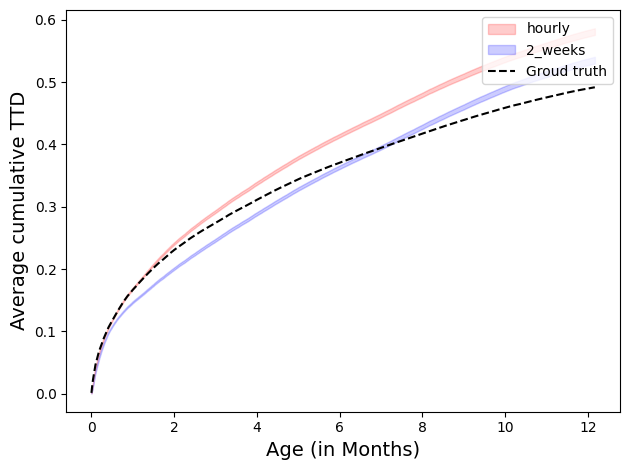

In [40]:
site2include = ['2_weeks', 'hourly']
def f(a):    
    res = False
    for site in site2include:
        res = res or (a[:len(site)]==site)
    return (res)
part_res = {site : value for site, value in results.items() if f(site)}
show_TTD_subsampling(part_res, site2include, nb_groups=10)

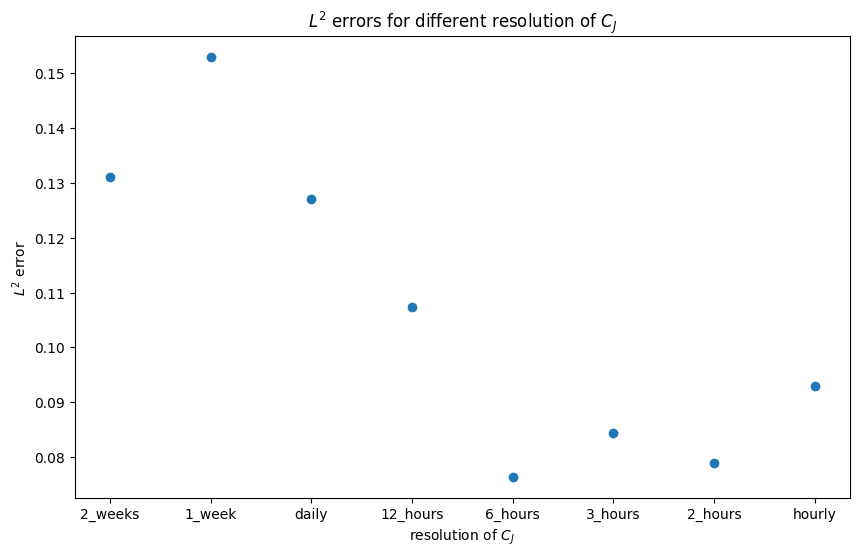

In [175]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the L2 errors for each model
l2_errors = []
model_names = []

mean_errors = []
models = []


for model, values in results.items():
    chat_values = np.array(values[algo]['Chat'])
    cout_values = np.array(values[algo]['Cout'])
    
    # Compute L2 error
    l2_error = np.sqrt((chat_values - cout_values) ** 2)
    
    # Store the errors and model names for plotting
    l2_errors.extend(l2_error)
    model_names.extend([model] * len(l2_error))

    models.append(model)
    mean_errors.append(np.mean(l2_error))

# Create the box plot using seaborn
plt.figure(figsize=(10, 6))
#sns.boxplot(x=model_names, y=np.log10(l2_errors))
plt.scatter([i for i in range(len(models))], mean_errors)
plt.xticks(ticks=[i for i in range(len(models))], labels=models)
plt.title('$L^2$ errors for different resolution of $C_J$')
plt.xlabel('resolution of $C_J$')
plt.ylabel('$L^2$ error')
plt.show()

# Biweekly model on training data

In [6]:
#['2_weeks','1_week','daily','6_hours']
site = '2_weeks'
seed='0'
pathsite = f'/mydata/watres/quentin/code/TRANSPORT/data/Pully_small_storage/subsampling/{site}/'
algo = 'SumSquares_noBERT2_bayesian3'
site_name2save=site+'_noise_0.1_yearstrain_'+str(years_training)+'_'+str(seed)
x = {
    'site': f'{site}',
    'pathsite': pathsite,
    'algo': algo,
    'path_model': os.path.join(pathsite, 'save', f'save_BERT4TRANSIT_{site_name2save}_no_c_{algo}.pth.tar'),
    'path_results': os.path.join(pathsite, 'save', f'results_{site_name2save}.pkl')
    }
model = BERT4Transit(pathsite=x['pathsite'], site=x['site'], algo=x['algo'], path_model=x['path_model'])
def filter_dates(dates):
    idxs1 = np.where(dates<=2022)[0]
    idxs2 = np.where(dates>=2020)[0]
    return np.intersect1d(idxs1, idxs2)
def filter_dates_train(dates):
    idxs = filter_dates(dates)
    return np.intersect1d(idxs, model.lst_train)
res = model.model_estimate(filter_dates, BATCH_SIZE=1000)
res_train = model.model_estimate(filter_dates_train, BATCH_SIZE=400)

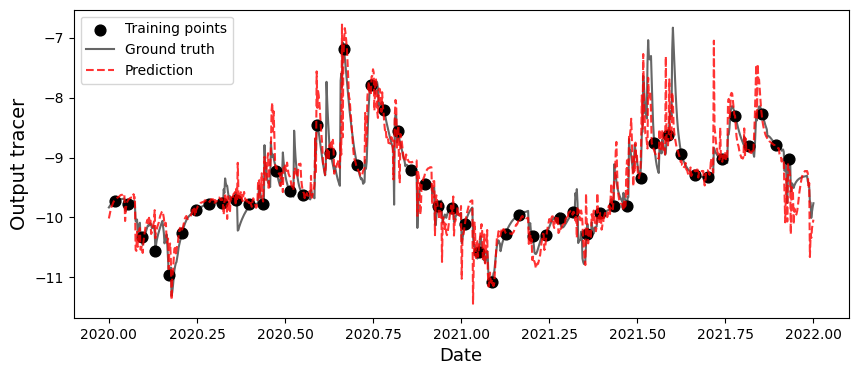

In [26]:
def show_Cout_train(res, res_train):
    fig, ax = plt.subplots(figsize=(10,4))
    ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False, useMathText=False))
    lst_train = res_train['timeyear']
    #plt.scatter(lst_test, res_train['Chat'], c='red')
    
    lst_test = res['timeyear']
    plt.scatter(lst_train, res_train['Cout'],   c='black', s=60, label='Training points')
    plt.plot(lst_test, res['Cout'],  c='black', linestyle='-', alpha=0.6, label='Ground truth')
    plt.plot(lst_test, res['Chat'],  c='red', linestyle='--',  alpha=0.8, label='Prediction')
    plt.xlabel('Date', fontsize=13)
    plt.ylabel('Output tracer', fontsize=14)
    plt.legend()
    plt.savefig('2weeks_CQ_training.png', dpi=250, bbox_inches="tight")
    plt.show()
show_Cout_train(res, res_train)

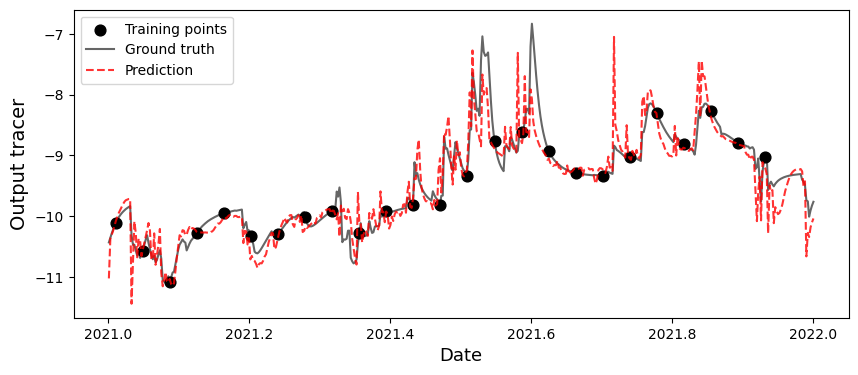

In [25]:
def show_Cout_train(res, res_train):
    fig, ax = plt.subplots(figsize=(10,4))
    ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False, useMathText=False))
    lst_train = res_train['timeyear']
    idxs_train = np.where(lst_train>=2021)[0]
    #plt.scatter(lst_test, res_train['Chat'], c='red')
    
    lst_test = res['timeyear']
    idxs = np.where(lst_test>=2021)[0]
    plt.scatter(lst_train[idxs_train], res_train['Cout'][idxs_train],   c='black', s=60, label='Training points')
    plt.plot(lst_test[idxs], res['Cout'][idxs],  c='black', linestyle='-', alpha=0.6, label='Ground truth')
    plt.plot(lst_test[idxs], res['Chat'][idxs],  c='red', linestyle='--',  alpha=0.8, label='Prediction')
    plt.xlabel('Date', fontsize=13)
    plt.ylabel('Output tracer', fontsize=14)
    plt.legend()
    plt.savefig('2weeks_CQ_training_1year.png', dpi=250, bbox_inches="tight")
    plt.show()
show_Cout_train(res, res_train)

# Biweekly model on test data

In [84]:
#['2_weeks','1_week','daily','6_hours']
site = '2_weeks'
seed='0'
pathsite = f'/mydata/watres/quentin/code/TRANSPORT/data/Pully_small_storage/subsampling/{site}/'
algo = 'SumSquares_noBERT2_bayesian3'
site_name2save=site+'_noise_0.1_yearstrain_'+str(years_training)+'_'+str(seed)
x = {
    'site': f'{site}',
    'pathsite': pathsite,
    'algo': algo,
    'path_model': os.path.join(pathsite, 'save', f'save_BERT4TRANSIT_{site_name2save}_no_c_{algo}.pth.tar'),
    'path_results': os.path.join(pathsite, 'save', f'results_{site_name2save}.pkl')
    }
model = BERT4Transit(pathsite=x['pathsite'], site=x['site'], algo=x['algo'], path_model=x['path_model'])
def filter_dates(dates, mode='training'):
    if mode=='training':
        idxs1 = np.where(dates<=2022)[0]
        idxs2 = np.where(dates>=2020)[0]
    else:
        idxs1 = np.where(dates<=2023)[0]
        idxs2 = np.where(dates>=2022)[0]
    return np.intersect1d(idxs1, idxs2)
def filter_dates_train(dates):
    idxs = filter_dates(dates)
    return np.intersect1d(idxs, model.lst_train)
res = model.model_estimate(filter_dates, BATCH_SIZE=1000)
res_train = model.model_estimate(filter_dates_train, BATCH_SIZE=400)
res_test = model.model_estimate(lambda x: filter_dates(x, mode='test'), BATCH_SIZE=1000)

TypeError: Results.model_estimate() got an unexpected keyword argument 'mode'

In [85]:
res_test = model.model_estimate(lambda x: filter_dates(x, mode='test'), BATCH_SIZE=1000)

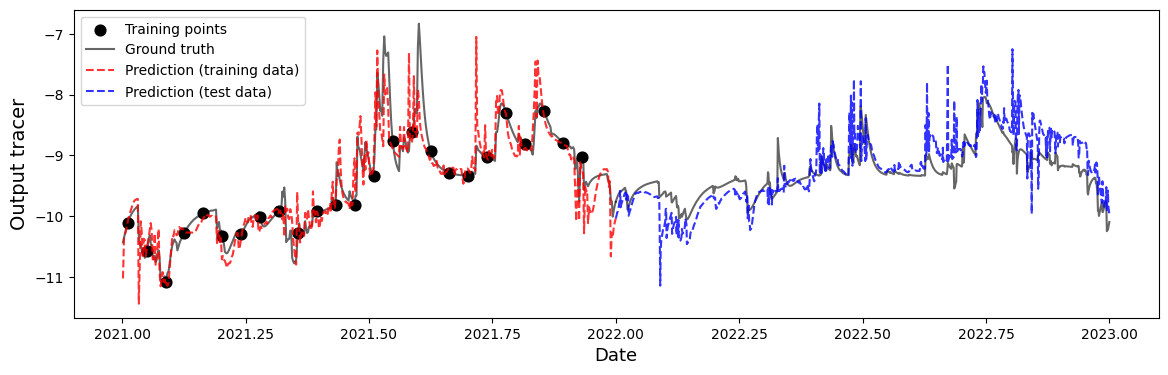

In [91]:
def show_Cout(res, res_train, res_test):
    fig, ax = plt.subplots(figsize=(14,4))
    ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False, useMathText=False))
    lst_train = res_train['timeyear']
    idxs_train = np.where(lst_train>=2021)[0]
    #plt.scatter(lst_test, res_train['Chat'], c='red')
    
    lst_test = res['timeyear']
    idxs = np.where(lst_test>=2021)[0]
    plt.scatter(lst_train[idxs_train], res_train['Cout'][idxs_train],   c='black', s=60, label='Training points')
    plt.plot(lst_test[idxs], res['Cout'][idxs],  c='black', linestyle='-', alpha=0.6, label='Ground truth')
    plt.plot(lst_test[idxs], res['Chat'][idxs],  c='red', linestyle='--',  alpha=0.8, label='Prediction (training data)')

    lst_test = res_test['timeyear']
    plt.plot(lst_test, res_test['Cout'],  c='black', linestyle='-', alpha=0.6)
    plt.plot(lst_test, res_test['Chat'],  c='blue', linestyle='--',  alpha=0.8, label='Prediction (test data)')
    plt.xlabel('Date', fontsize=13)
    plt.ylabel('Output tracer', fontsize=14)
    plt.legend()
    plt.savefig('2weeks_CQ_training_and_test.png', dpi=250, bbox_inches="tight")
    plt.show()
show_Cout(res, res_train, res_test)

In [ ]:
def show_ywf(res, res_train, res_test):
    fig, ax = plt.subplots(figsize=(10,4))
    ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False, useMathText=False))
    lst_train = res_train['timeyear']
    idxs_train = np.where(lst_train>=2021)[0]
    #plt.scatter(lst_test, res_train['Chat'], c='red')
    
    lst_test = res['timeyear']
    idxs = np.where(lst_test>=2021)[0]
    plt.scatter(lst_train[idxs_train], res_train['Cout'][idxs_train],   c='black', s=60, label='Training points')
    plt.plot(lst_test[idxs], res['Cout'][idxs],  c='black', linestyle='-', alpha=0.6, label='Ground truth')
    plt.plot(lst_test[idxs], res['ywfhat'][idxs],  c='red', linestyle='--',  alpha=0.8, label='Prediction (training data)')

    lst_test = res_test['timeyear']
    plt.plot(lst_test, res_test['Cout'],  c='black', linestyle='-', alpha=0.6)
    plt.plot(lst_test, res_test['ywfhat'],  c='blue', linestyle='--',  alpha=0.8, label='Prediction (test data)')
    plt.xlabel('Date', fontsize=13)
    plt.ylabel('Output tracer', fontsize=14)
    plt.legend()
    plt.savefig('2weeks_CQ_training_and_test.png', dpi=250, bbox_inches="tight")
    plt.show()
show_Cout(res, res_train, res_test)

In [28]:
import copy
sites = ['2_weeks','daily','hourly']
allres = {}
for site in sites:
    seed='0'
    pathsite = f'/mydata/watres/quentin/code/TRANSPORT/data/Pully_small_storage/subsampling/{site}/'
    algo = 'SumSquares_noBERT2'
    x = {
        'site': f'{site}',
        'pathsite': pathsite,
        'algo': algo,
        'path_model': os.path.join(pathsite, 'save', f'save_BERT4TRANSIT_{site}_{seed}_no_c_{algo}.pth.tar'),
        'path_results': os.path.join(pathsite, 'save', f'results_{site}_{seed}.pkl')
        }
    model = BERT4Transit(pathsite=x['pathsite'], site=x['site'], algo=x['algo'], path_model=x['path_model'])
    def filter_dates(dates):
        idxs1 = np.where(dates<=2022)[0]
        idxs2 = np.where(dates>=2020)[0]
        return np.intersect1d(idxs1, idxs2)
    def filter_dates_train(dates):
        idxs = filter_dates(dates)
        return np.intersect1d(idxs, model.lst_train)
    res = model.model_estimate(filter_dates, BATCH_SIZE=1000)
    allres[site] = copy.deepcopy(res)

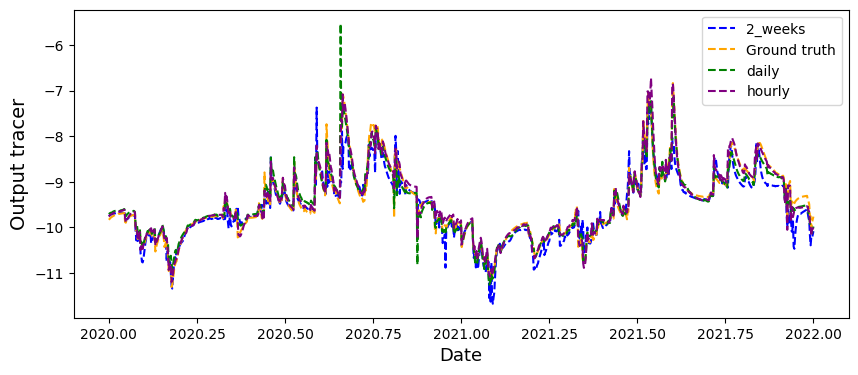

In [32]:
def show_Cout_allresolutions(allres):
    fig, ax = plt.subplots(figsize=(10,4))
    ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False, useMathText=False))
    count = 0
    colors = ['blue','green','purple'] 
    for site, res in allres.items():
        lst_test = res['timeyear']
        plt.plot(lst_test, res['Chat'],  c=colors[count], linestyle='--', label=site)
        #plt.scatter(lst_test, res['Cout'], marker='x',  c='orange
        if count==0:
            plt.plot(lst_test, res['Cout'],  c='orange', linestyle='--', label='Ground truth')
        count += 1
    plt.xlabel('Date', fontsize=13)
    plt.ylabel('Output tracer', fontsize=14)
    plt.legend()
    plt.show()
show_Cout_allresolutions(allres)

# 1. Reproduced Output Tracer time series 

### Results on the total test set

In [268]:
def show_Cout(settings_algos, n_start=0, n_end=-1, algo2name=None, site2name=None):
    algo2name = get_names_algos(settings_algos, algo2name)
    for i in range(len(settings_algos)):
        site = settings_algos[i]['site']
        algo = settings_algos[i]['algo']
        with open(settings_algos[i]['path_results'], "rb") as input_file:
            result = pickle.load(input_file)  
        fig, ax = plt.subplots()
        ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False, useMathText=False))
        lst_test = result['timeyear_test'][:n_end][n_start:]
        plt.scatter(lst_test, result['Chat'][:n_end][n_start:], c='red')
        plt.plot(lst_test, result['Chat'][:n_end][n_start:],  c='red', linestyle='--', label='Predicted')
        plt.scatter(lst_test, result['Cout'][:n_end][n_start:], marker='x',  c='orange')
        plt.plot(lst_test, result['Cout'][:n_end][n_start:],  c='orange', linestyle='--', label='Ground truth')
        plt.title(site2name[site])
        plt.xlabel('Date', fontsize=13)
        plt.ylim([-10.5, -7])
        plt.ylabel('Output tracer', fontsize=14)
        plt.legend()
        plt.savefig(f'watres_reproduced_cq_{site2name[site]}.png', dpi=250, bbox_inches="tight")
        plt.show()

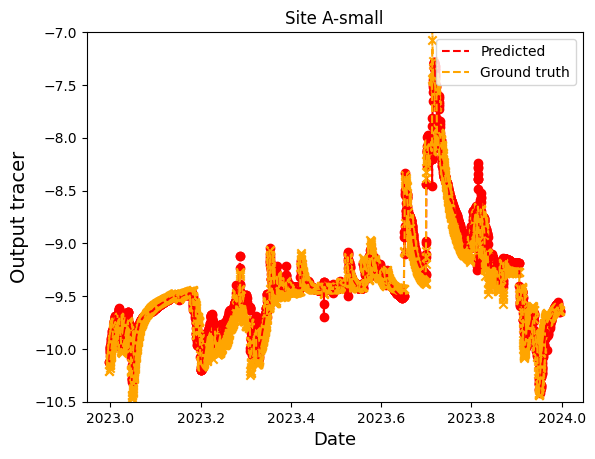

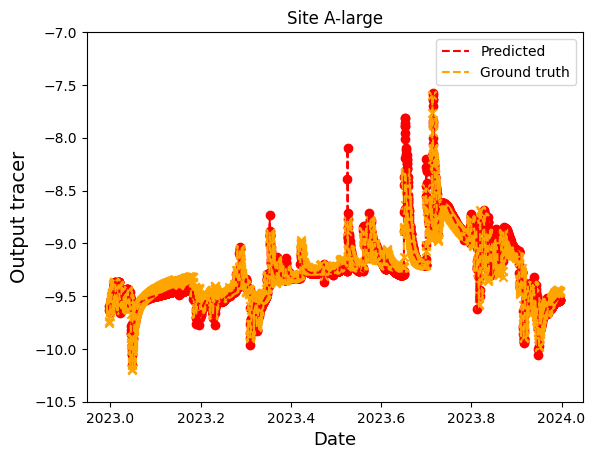

In [269]:
show_Cout(settings, algo2name=algo2name, site2name=site2name)

### Zooming on a subset of the test set

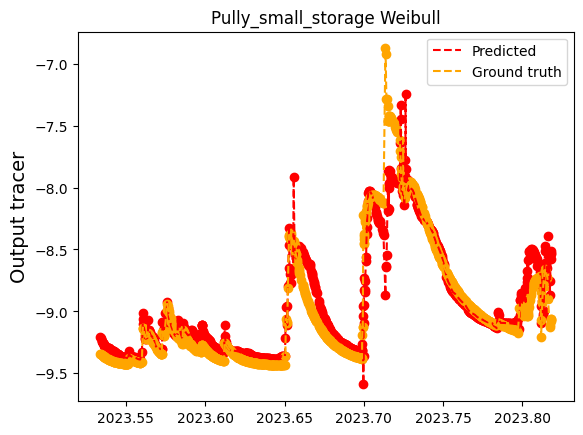

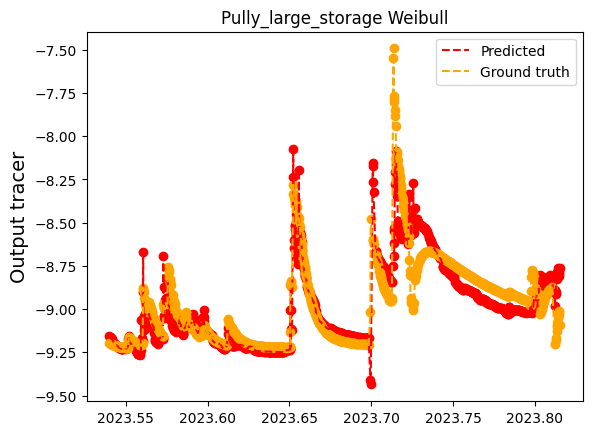

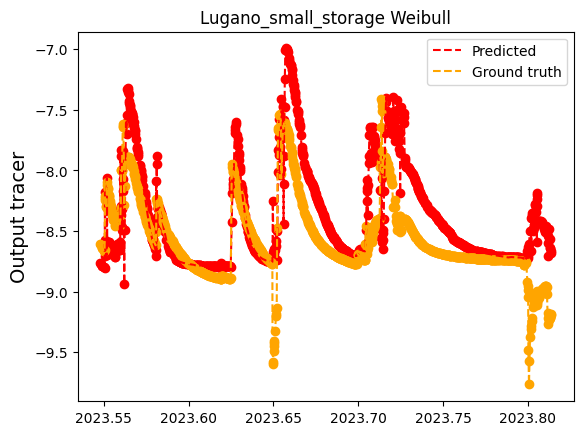

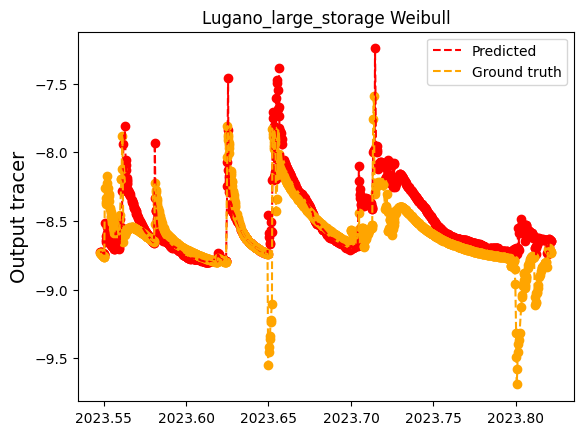

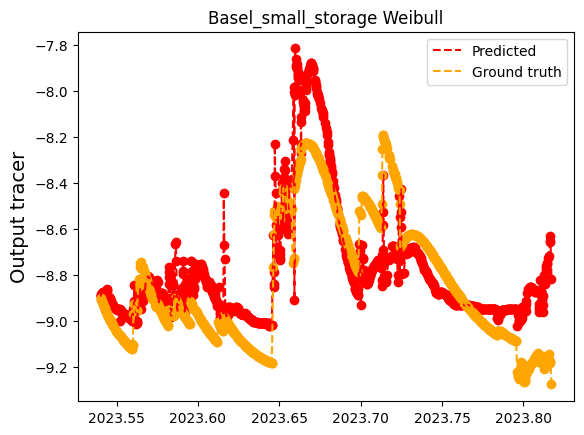

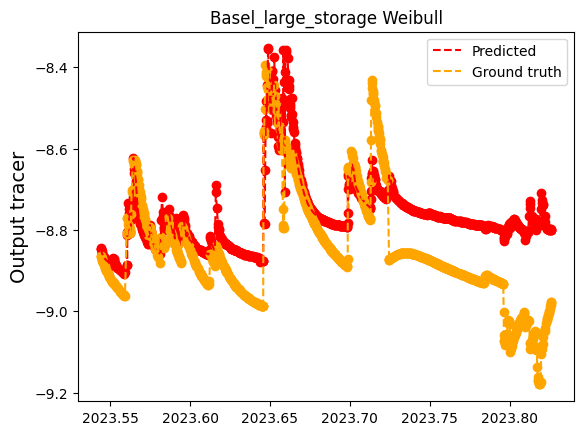

In [14]:
show_Cout(settings, n_start=2000, n_end=3000, algo2name=algo2name)

# 2. Estimated Young Water Fraction

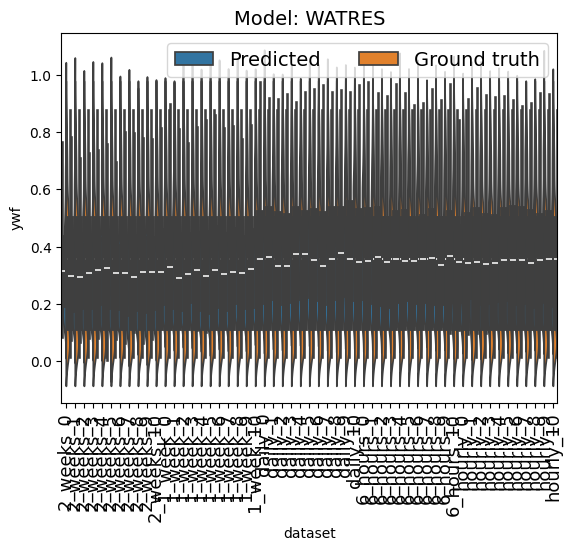

In [16]:
show_violin_ywf(results, algo2name=algo2name)

In [176]:

def show_ywf(results, algo2name=None, site2name=None):
    size_marker = 100
    algo2name = get_names_algos(results, algo2name)
    if site2name is None:
        site2name = {site: site for site in list(results.keys())}
    markers = ['*','+', 'x', '.', 'd','|']
    colors = ['red', 'orange', 'blue', 'brown', 'green', 'purple']
    mark = {algo:markers[i] for i,algo in enumerate(list(algo2name.keys()))}
    color = {algo:colors[i] for i,algo in enumerate(list(algo2name.keys()))}
    tickslabel = []
    count_fig = 0
    for site, res_site in results.items():
        count_fig += 1
        count_algo = 0
        for algo, value in res_site.items():
            mean_ywf = np.mean(res_site[algo]['ywfhat'][:, 2])
            if count_fig==1:
                plt.scatter([count_fig], mean_ywf, label=algo2name[algo], marker=mark[algo], c=color[algo], s=size_marker, alpha=0.6)
            else:
                plt.scatter([count_fig], mean_ywf, marker=mark[algo], c=color[algo], s=size_marker, alpha=0.6)
            count_algo += 1
            if count_algo==1:
                mean_ywf_true = np.mean(res_site[algo]['ywf_true'][:,2])
                if count_fig==1:
                    plt.scatter([count_fig], mean_ywf_true, label='Ground truth', marker='_', c='black', s=size_marker)
                else:
                    plt.scatter([count_fig], mean_ywf_true, marker='_', c='black', s=size_marker)

        tickslabel.append(site2name[site])
        

    plt.xticks(list(range(1,count_fig+1)), tickslabel, rotation = 90, fontsize=13)
    plt.legend(
        fontsize=12,
        loc='center',         # Position legend to the left center
        bbox_to_anchor=(0.5, 1.12),   # Move it outside the plot, centered vertically
        ncol=2                     # Set the number of columns
    )

    plt.ylabel('Young water fraction', fontsize=14)
    #plt.savefig('/data/quentin/code/final_models/BERT/BERT_multi_MODEL_standard_improved/results_paper3_guided/figures/ywf_values'+'_'+label_concen+'.png', dpi=300, bbox_inches="tight")
    plt.show()

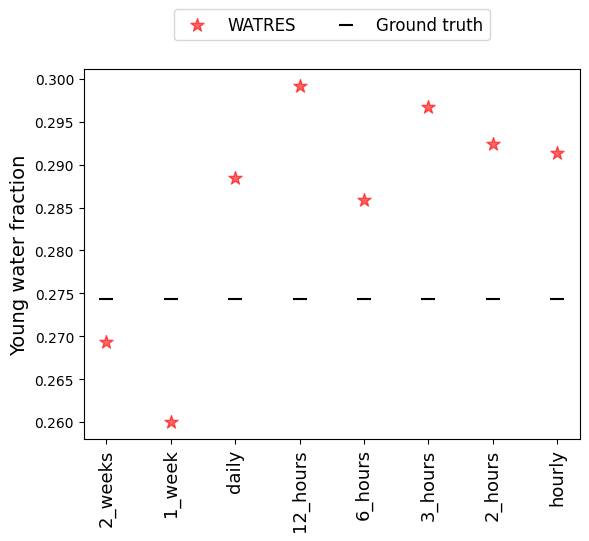

In [177]:
show_ywf(results, algo2name=algo2name)

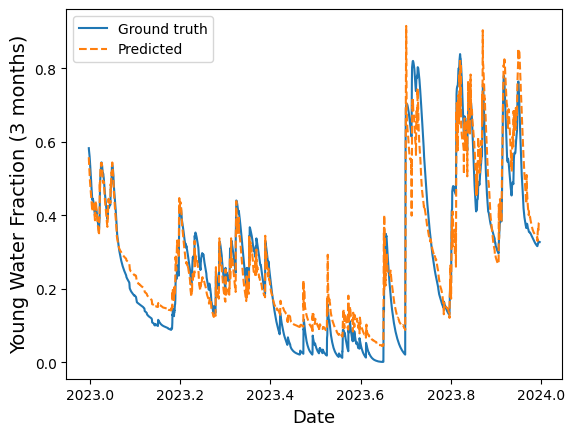

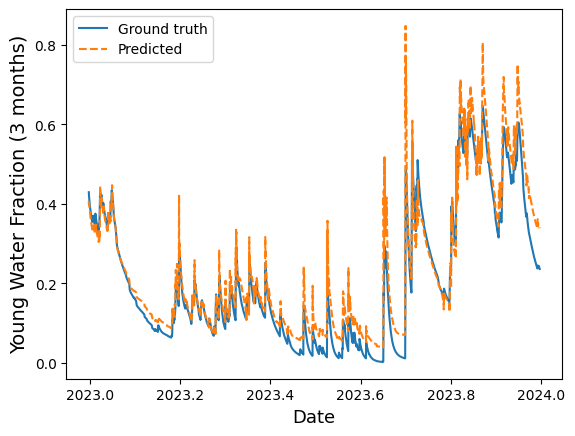

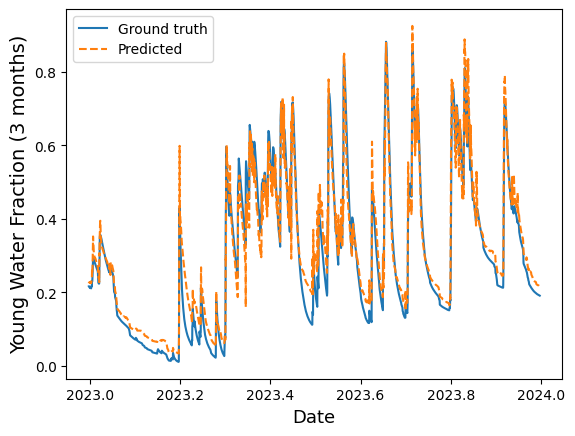

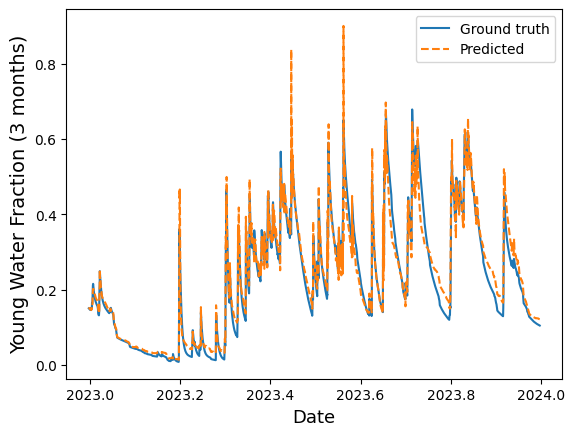

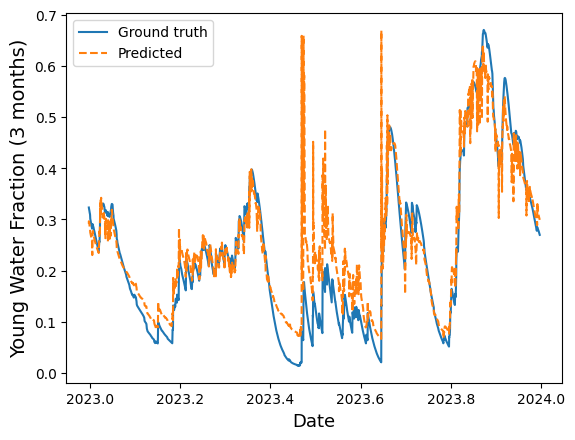

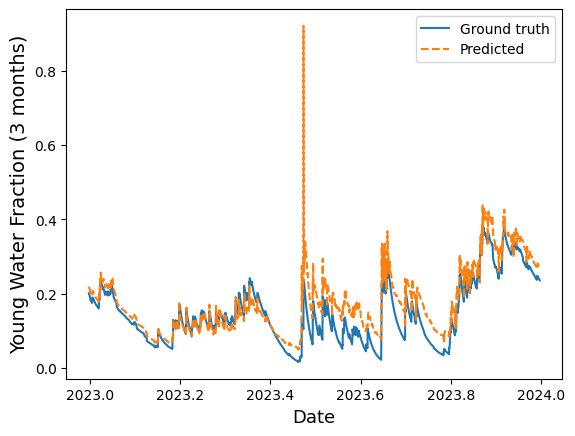

In [264]:
show_TS_ywf(results, algo2name=algo2name)

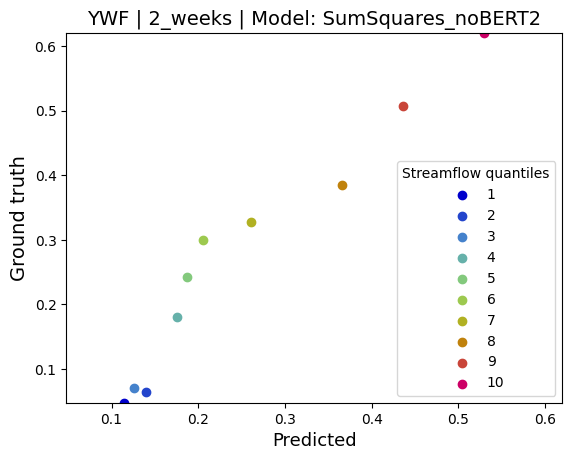

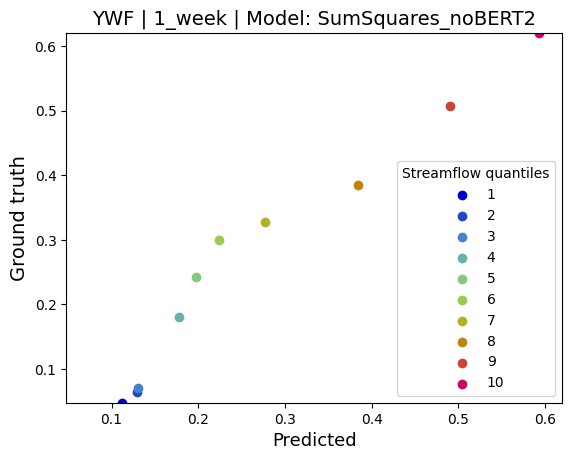

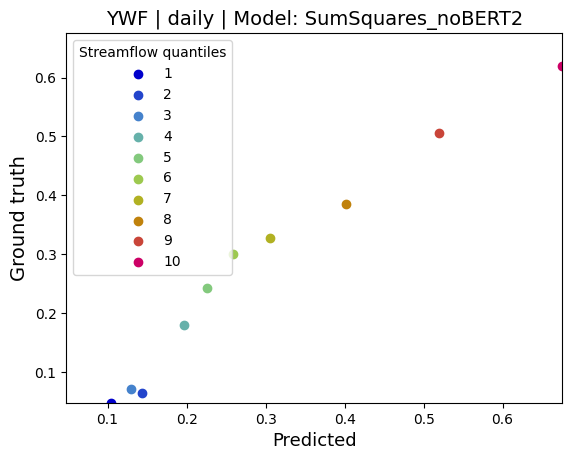

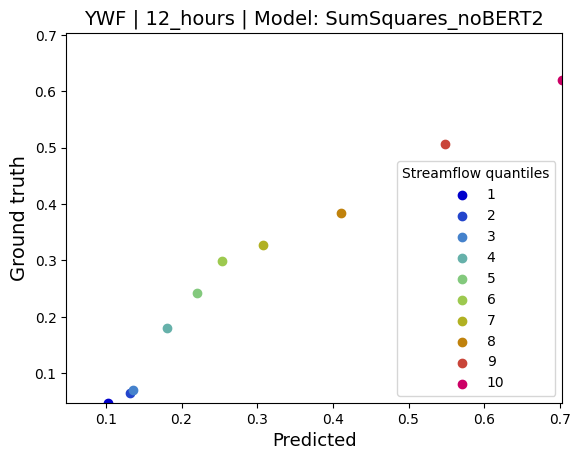

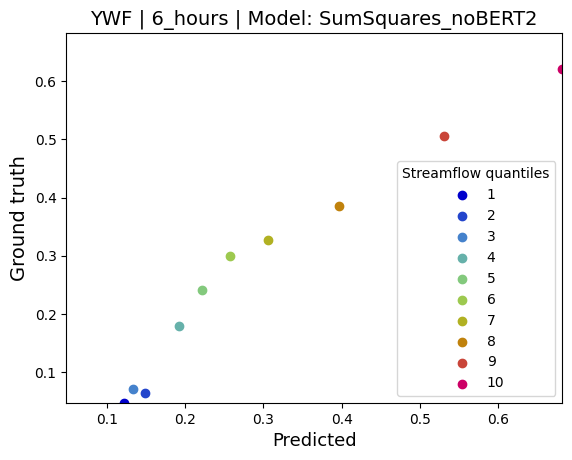

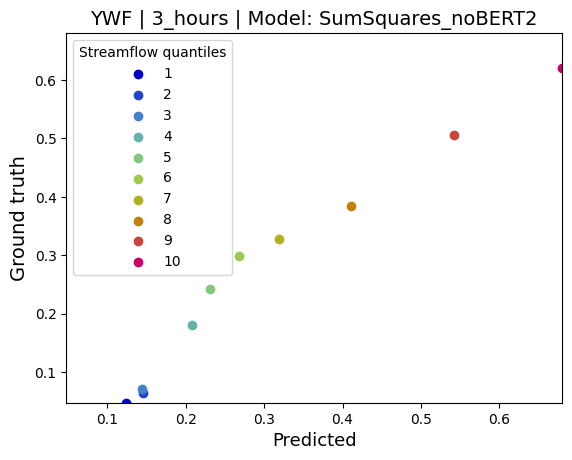

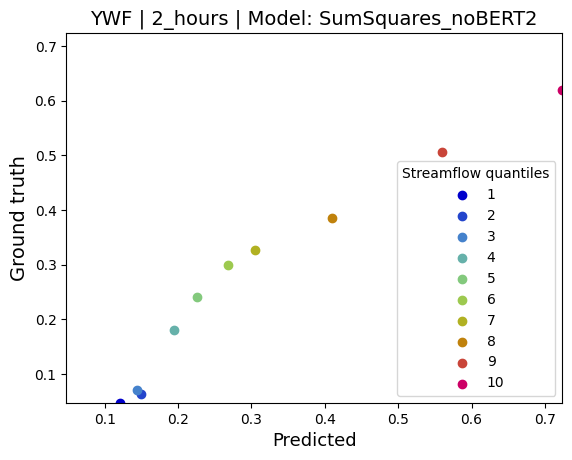

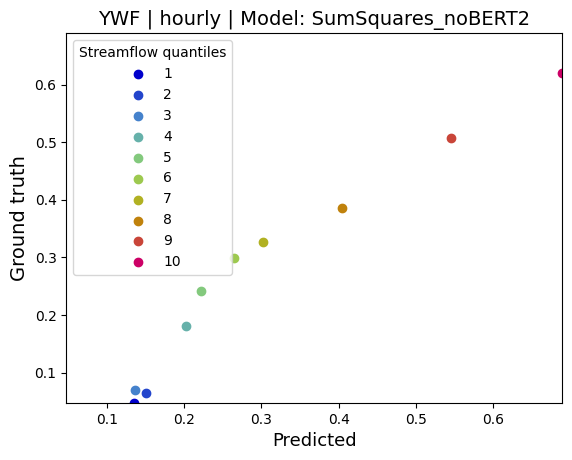

In [149]:
show_quantile_ywf(results)#, site2name=site2name)

In [12]:
def show_quantile_ywf_single_figure(results, nb_groups = 10, months_ywf=3, algo2name=None, site2name=None):
    from matplotlib.lines import Line2D
    if site2name is None:
        site2name = list(results.keys())
    count_site = -1
    algo2name = get_names_algos(results, algo2name)
    colors = np.flip(get_colors_rainbow(K=nb_groups))
    markers = ["o", "s", "D", "*", "X", "v", "P"]

    min_val_glob, max_val_glob = 1, 0
    for site, res_site in results.items():
        count_site += 1
        for algo, value in res_site.items():
            Q_test = value['Q_test']
            # Get quantile bins (10 quantiles)
            quantile_bins = np.quantile(Q_test, np.linspace(0, 1, nb_groups+1))
            # Assign each value to a quantile bin
            quantile_indexes = np.digitize(Q_test, quantile_bins, right=True)
            # Create a dictionary to hold the indexes for each group
            grouped_indexes = {i: np.where(quantile_indexes == i)[0] for i in range(1, nb_groups+1)}

            data_pred = []
            data_true = []
            
            for idx_group, idxs in grouped_indexes.items():
                if len(idxs) > 0:
                    data_pred.append(np.mean(value['ywfhat'][:, months_ywf-1][idxs]))
                    data_true.append(np.mean(value['ywf_true'][:, months_ywf-1][idxs]))

            # Find the axis limits based on the data
            all_data = np.concatenate((data_pred, data_true))
            min_val, max_val = np.min(all_data), np.max(all_data)
            max_val_glob = max([max_val_glob, max_val])
            min_val_glob = min([min_val_glob, min_val])

            
            # Plot with different colors for each group and create a legend entry
            for i in range(1, nb_groups+1):
                if i in grouped_indexes and len(grouped_indexes[i]) > 0:
                    plt.scatter(
                        np.mean(value['ywfhat'][:, months_ywf-1][grouped_indexes[i]]),
                        np.mean(value['ywf_true'][:, months_ywf-1][grouped_indexes[i]]),
                        color=colors[i-1],
                        marker=markers[count_site]
                    )
    

    min_val_glob -= 0.05
    min_val_glob = max([min_val_glob,0])
    max_val_glob += 0.05
    # Set the same limits for x and y axes
    plt.xlim(min_val_glob, max_val_glob)
    plt.ylim(min_val_glob, max_val_glob)
    plt.plot([min_val_glob, max_val_glob], [min_val_glob, max_val_glob], linestyle='--', color='black')
    plt.xlabel('Predicted', fontsize=13)
    plt.ylabel('Ground truth', fontsize=14)
    # Custom legend for colors (Streamflow quantiles)
    color_legend = [Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i-1], markersize=10)
                    for i in range(1, nb_groups+1)]
    quantile_legend = plt.legend(color_legend, [f'Q{i}' for i in range(1, nb_groups+1)], 
                                 title="Streamflow quantiles",
                                 loc=5, bbox_to_anchor=(0.93, 0.2), ncol=2)
    
    # Add the color legend to the plot
    plt.gca().add_artist(quantile_legend)

    # Custom legend for markers (Sites)
    marker_legend = [Line2D([0], [0], marker=markers[i], color='w', markerfacecolor='grey', markersize=10)
                     for i in range(len(site2name))]
    plt.legend(marker_legend, site2name.values(), title="Sites", loc=1, bbox_to_anchor=(0.6, 0.95), ncol=2)

    plt.tight_layout()
    plt.savefig('ywf_true_vs_pred.png', dpi=250, bbox_inches="tight")
    plt.show()

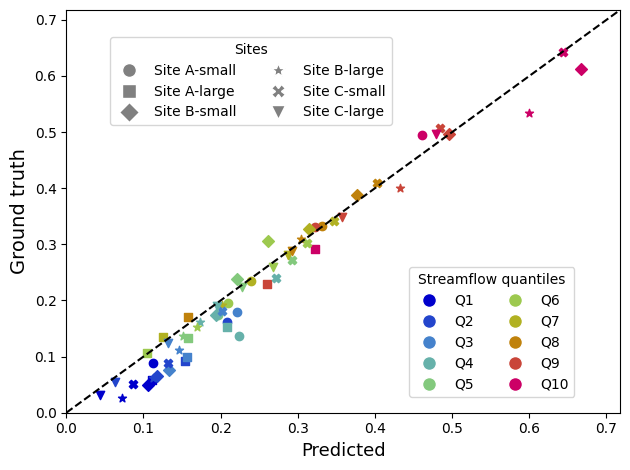

In [13]:
show_quantile_ywf_single_figure(results, site2name=site2name, nb_groups=10)

# 3. Cumulative TTDs

In [123]:

def show_global_cum_ttd(results, algo2name=None):
    count_fig = 0
    for site, res_site in results.items():
        for algo, value in res_site.items():
            plt.figure(count_fig)
            plt.plot(results[site][algo]['global_PQhat'], label='Prediction')
            plt.xlabel('Age (in Months)', fontsize=13)
            plt.ylabel('Global cumulative TTD', fontsize=14)
            plt.legend()
            plt.title(site+'  '+algo2name[algo], fontsize=14)
            plt.show()
            count_fig += 1


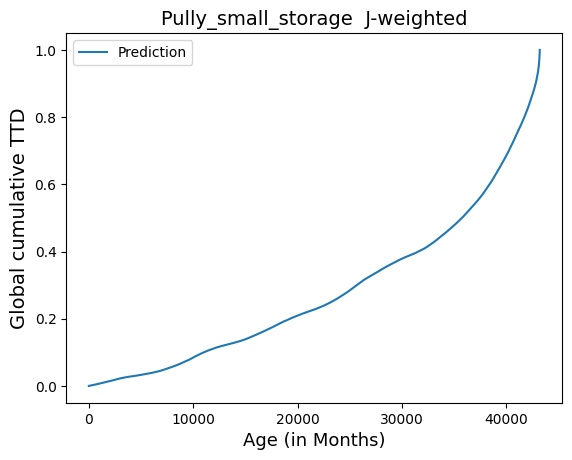

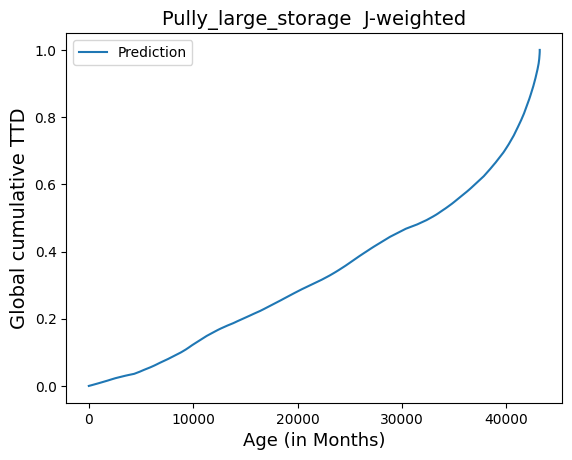

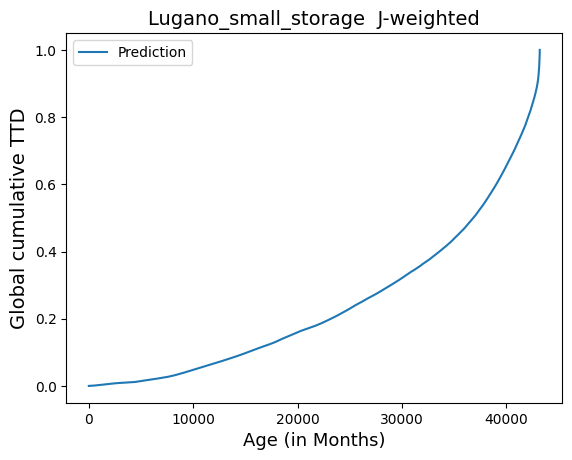

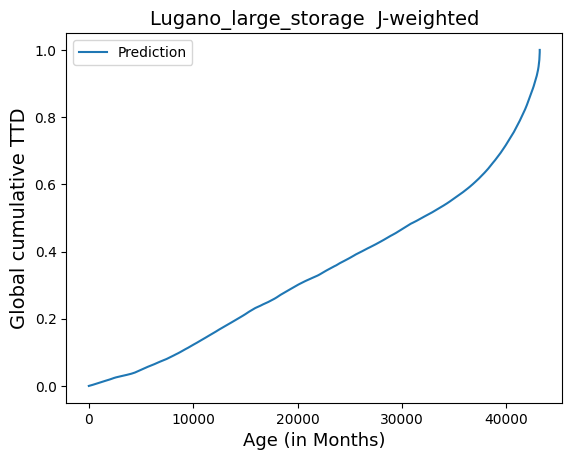

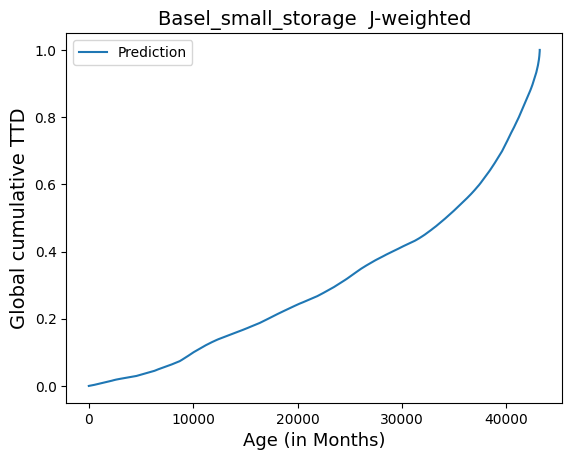

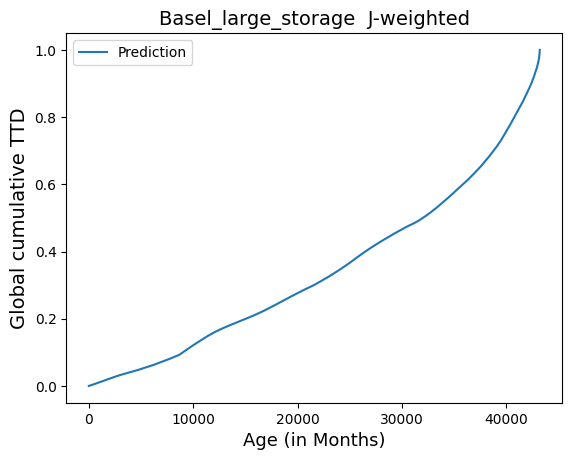

In [124]:
show_global_cum_ttd(results, algo2name=algo2name)

# 4. Survival functions

<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1245/539625748.py:6: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('$T\mapsto Log_{10}(w_{season}(T))$', fontsize=14)


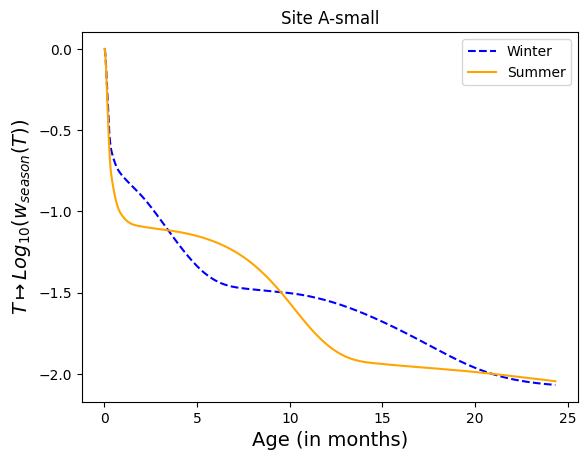

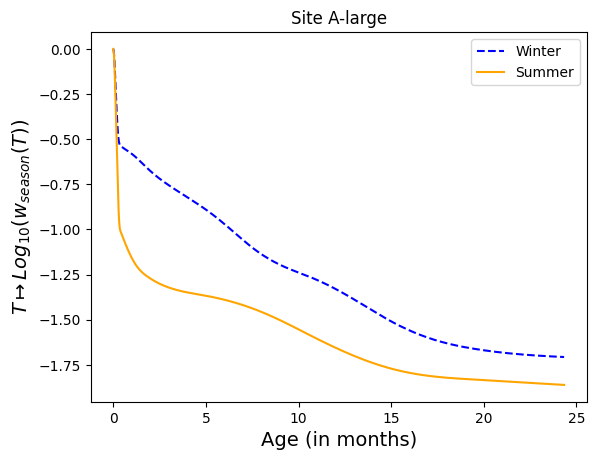

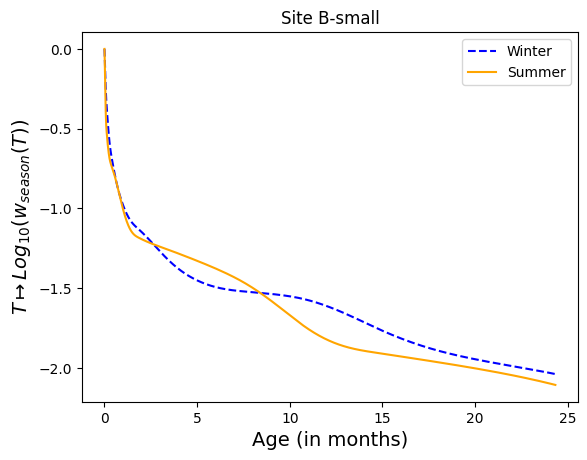

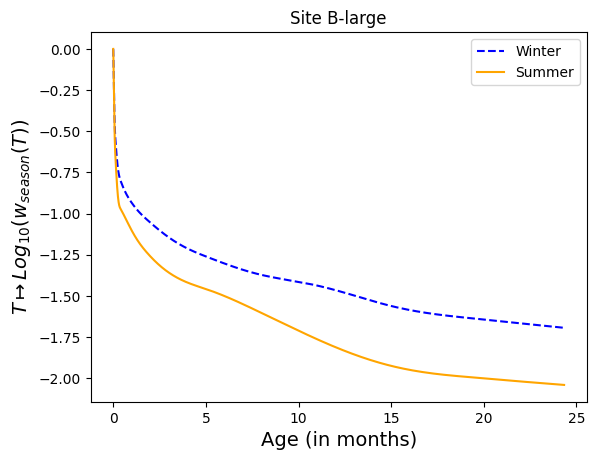

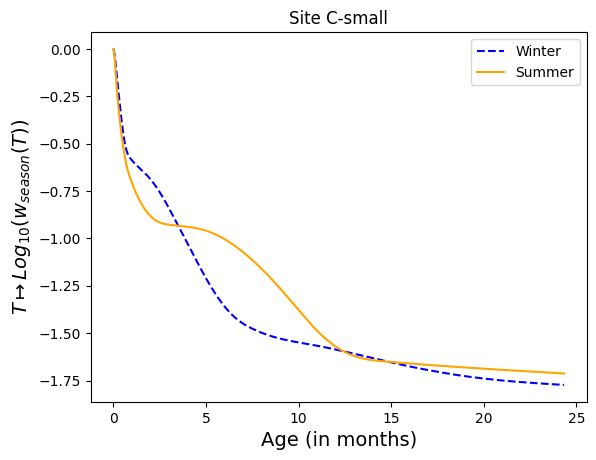

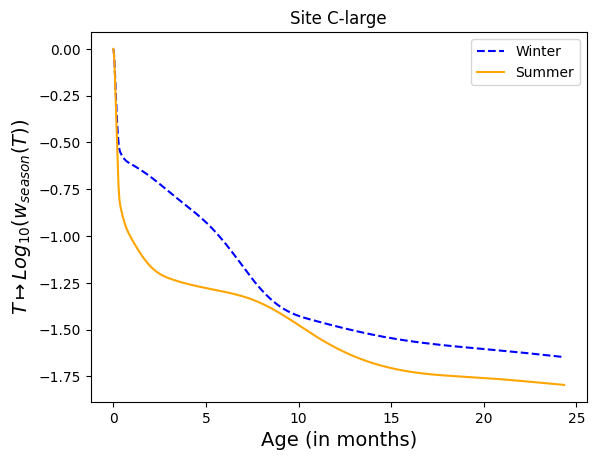

In [112]:
for site in sites:
    plt.plot(np.arange(2*24*365)/(24*30), np.log10(results[site][algo]['w_winter'][:2*24*365]), linestyle='--', color='blue', label='Winter')
    plt.plot(np.arange(2*24*365)/(24*30), np.log10(results[site][algo]['w_summer'][:2*24*365]), color='orange', label='Summer')
    plt.legend()
    plt.xlabel('Age (in months)', fontsize=14)
    plt.ylabel('$T\mapsto Log_{10}(w_{season}(T))$', fontsize=14)
    plt.title(site2name[site])
    plt.savefig(f'w_season_{site2name[site]}.png',  dpi=250, bbox_inches="tight")
    plt.show()

## The code below allows to visualize time specific TTDs for Pully small storage

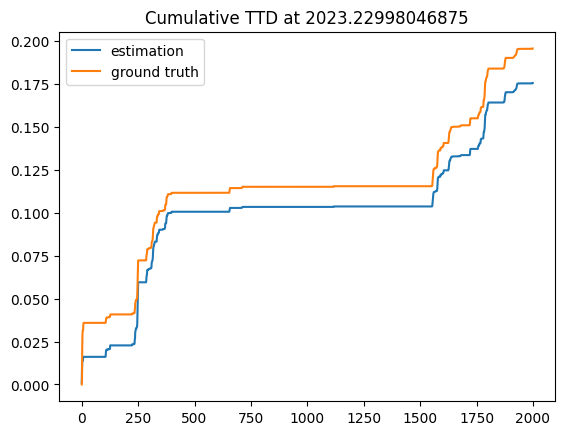

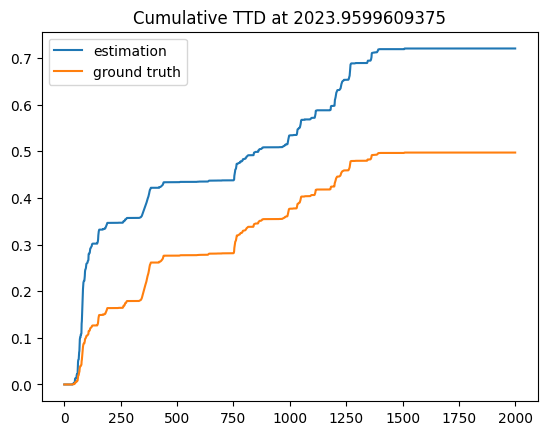

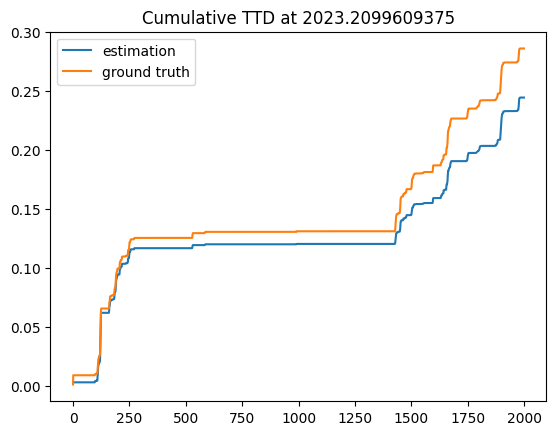

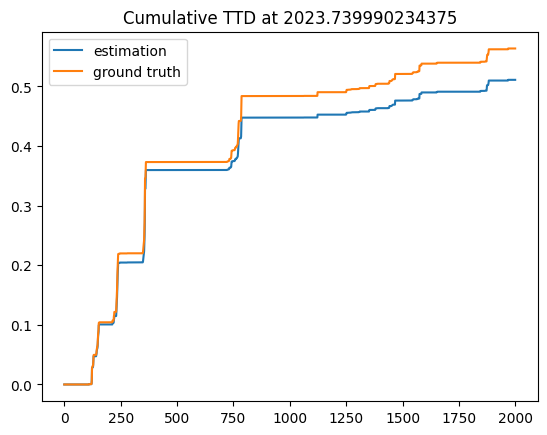

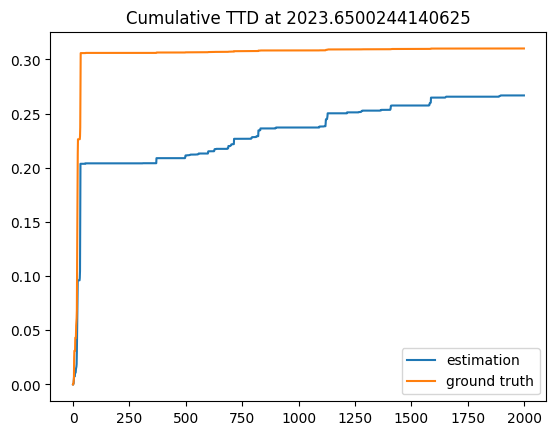

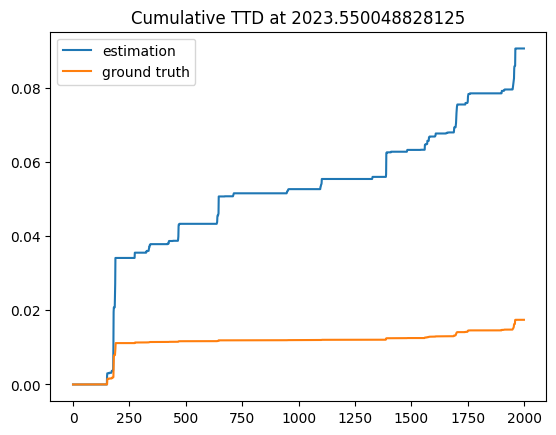

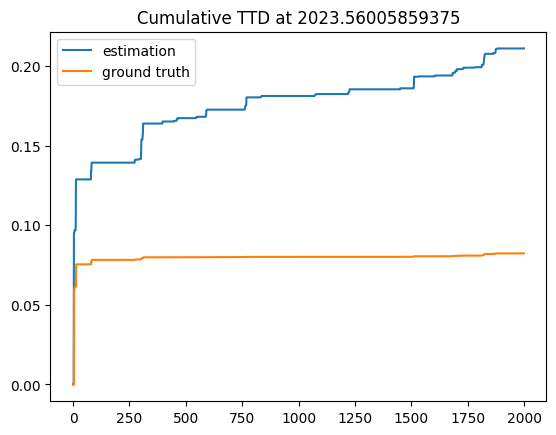

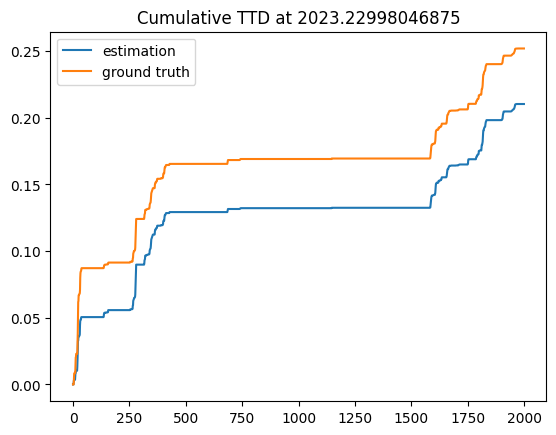

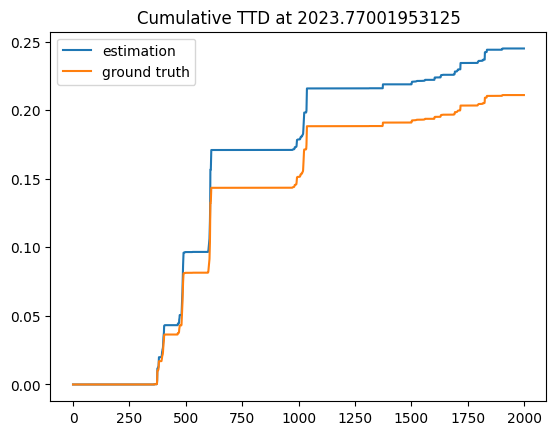

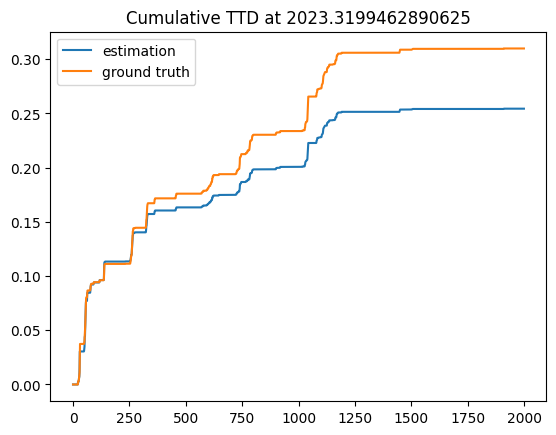

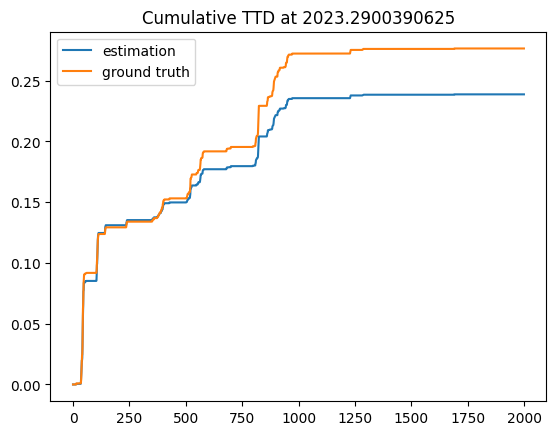

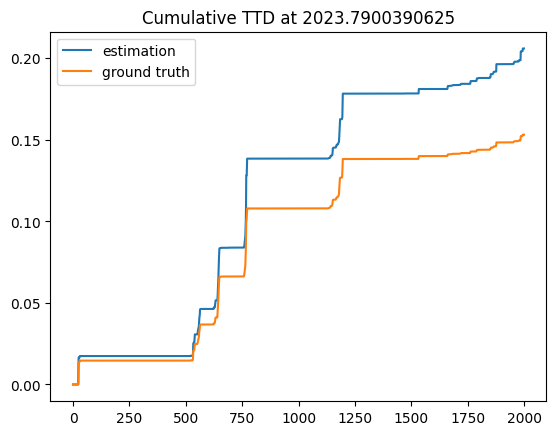

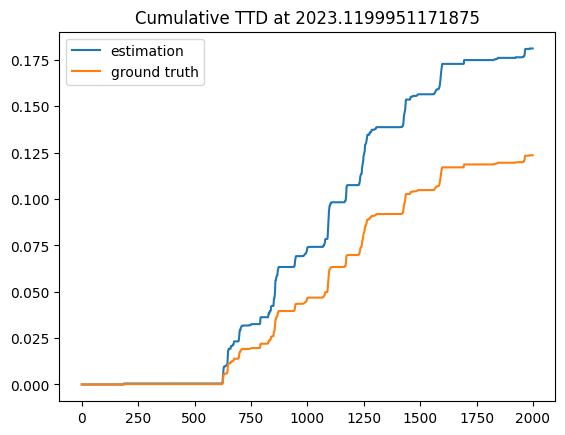

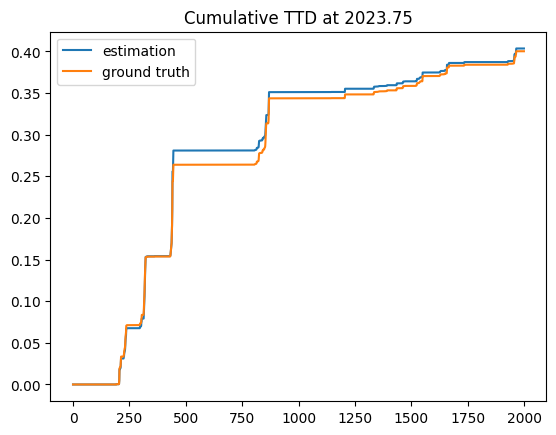

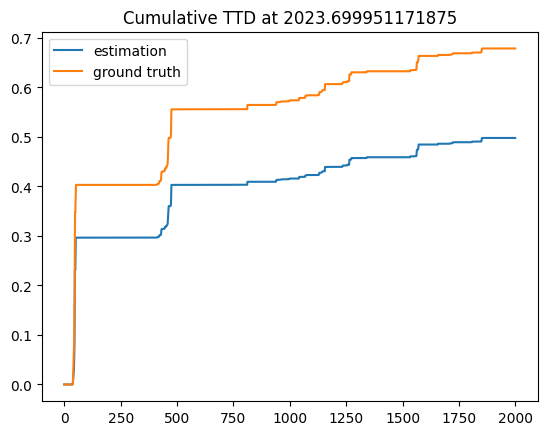

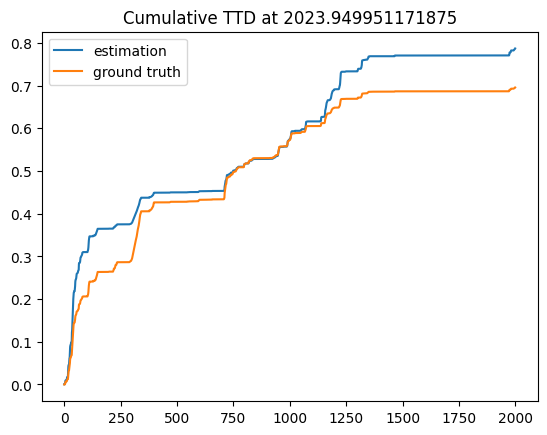

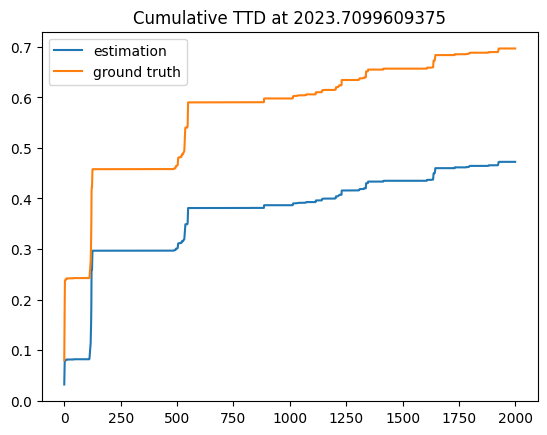

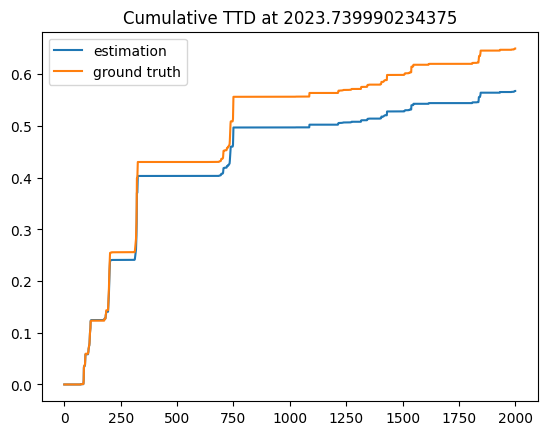

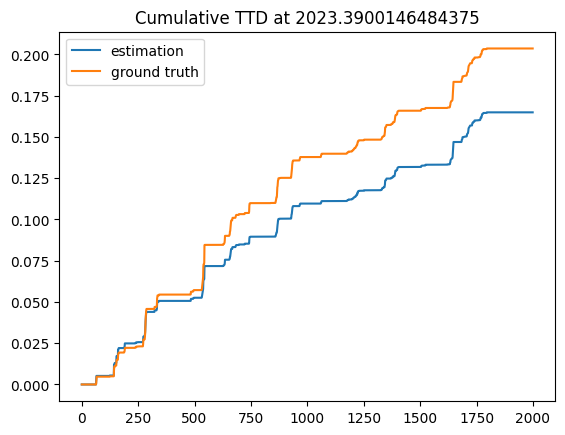

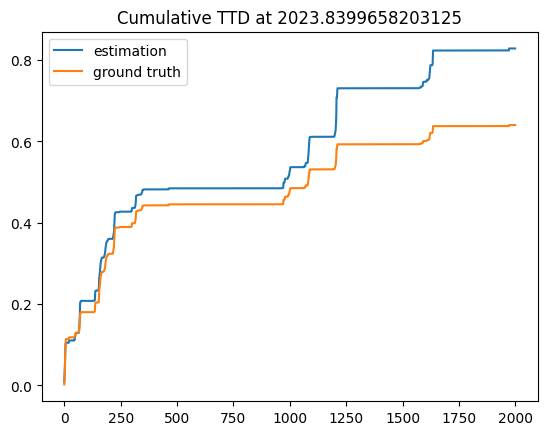

In [44]:
for i in range(20,40):
    n = results[sites[0]][algo]['PQhat'].shape[1]
    import random
    t = random.randint(0, n)
    plt.plot(results[sites[0]][algo]['PQhat'][:2000,t], label='estimation')
    plt.plot(results[sites[0]][algo]['PQtrue'][t,:2000], label='ground truth')
    plt.title('Cumulative TTD at {0}'.format(np.round(results[sites[0]][algo]['timeyear_test'][t], 2)))
    plt.legend()
    plt.show()